In [ ]:
import myServices as ms
import models as md

import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [ ]:
# to compute ececution time do: 
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
### Import DataSet 
readSetPath = 'datasets/datasets4MLP/'
importName = 'MLP_basin5_Test.csv'
saveDatasetPath = 'datasets/datasets4MLP_Binary/'
basinDataSet = pd.read_csv((readSetPath+importName), index_col = None)

basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)

exportName = 'MLPBinary_basin5_Test.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

basinDataSet.describe()
basinDataSet.head()

In [ ]:
colNames = ['percentage','DLSOL5R200', 'DLSOL4R150', 'DLSOL5R150']
for col in colNames: 
    basinDataSet[col].fillna(0,inplace=True)

In [ ]:
## Transform a column datatype
repalcer  = basinDataSet['percentage'].to_numpy().astype('int32')
print(repalcer[0:10],repalcer.dtype)
basinDataSet.loc[:,'percentage'] = repalcer

In [ ]:
### Make binary Dataset ###
# keep class_0 and replace with 1 all other classes. 
basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)


In [ ]:
basinDataSet.describe()

In [ ]:
basinDataSet.head()

In [ ]:
basinDataSet.isna().any()

In [ ]:
exportName = 'MLPBinary_basin3_Training.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

In [ ]:
### Replacing QGIS NoData value(-9999) with 0 
repalcer  = basinDataSet['FAProx_01'].to_numpy()
basinDataSet['FAProx_01'] = [0 if repalcer[j] == -9999 else repalcer[j] for j in range(len(repalcer))]                                                                                                                         
                                                                                                                          

In [ ]:
basinDataSet.dropna(subset=['slope'],inplace=True)

In [ ]:
basinDataSet.drop(['fid'], axis =1, inplace=True)

In [ ]:
basinDataSet.isna().sum()

In [ ]:
#### NOrmalize Flow Accumulation
basinDataSet['FAcc'] = (basinDataSet['FAcc']- basinDataSet['FAcc'].min())/(basinDataSet['FAcc'].max()-basinDataSet['FAcc'].min())


In [ ]:
ds = DS.head(5)
s = {}
s['Datas'] = ds
print(s)

## Proportional Spliting 

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasets/basin1_FirstFeatureSet_Clean.csv', 'percentage')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
## Describing training set
print(len(X_train['elevation']), len(y_train) )
trainCount = Counter(y_train)
print(trainCount)

In [ ]:
#####    Creating training set     #####
X_train.loc[:,'percentage'] = y_train
X_train.head()


In [ ]:
## Removing coordinates from training set
X_train.drop(['x_coord','y_coord'], axis =1, inplace=True)
X_train.head()

In [ ]:
X_train.to_csv('datasets/basin1_FirstFeatureSet_Clean_Training.csv', index=None)

In [ ]:
#####. Creating Test set
print(X_test.head())
X_test.loc[:,'percentage'] = y_test
print(X_test.head())
print(X_test.info())
testCount = Counter(X_test['percentage'])
print(f"testCount:  {testCount}")


In [ ]:
X_test.to_csv('datasets/basin1_FirstFeatureSet_Clean_Test.csv', index=None)

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression
totalTrain = sum([trainCount[0], trainCount[1], trainCount[5]]) 
totalValidation = sum([testCount[0], testCount[1], testCount[5]])
print(f"total Train samples: {totalTrain},  total Validation samples: {totalValidation}")
print("Summary of traning and test dataset class balance")
print(f"Training Set:", '\n', "Class 0: %.3f" %(trainCount[0]/totalTrain), " Class 1: %.4f" %(trainCount[1]/totalTrain), "Class 5: %.4f"%(trainCount[5]/totalTrain))
print("Testing Set:", '\n', "Class 0: %.3f" %(testCount[0]/totalValidation)," Class 1: %.4f" %(testCount[1]/totalValidation),  "Class 5: %.4f"%(testCount[5]/totalValidation))



In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

## Combining dataSets to build AllVsOne_training and OneVsAll_test

In [ ]:
# Concat datasets
sourceFileForDatasets = 'datasets/'
allDataSetsNames = ['basin1Light_Clean.csv', 'basin2_CleanDataSet.csv', 'basin3_CleanDataSet_copy.csv','basin4_CleanDataSet.csv','basin5_CleanDataSet.csv']
# OneVsAllDataSetName = 'basin1Light_Clean.csv'

for datasetForTest in allDataSetsNames:
    filename, file_extension = os.path.splitext(datasetForTest)
    newListOfNames = [s for s in allDataSetsNames if s != datasetForTest]
    allDataSetsFileName = 'allVs_'+ filename +'_Training'
    DFToConcatAll = pd.DataFrame()
#     DFToConcatAll = pd.read_csv((sourceFileForDatasets+datasetForTest), index_col = None)
#     print(DFToConcatAll.head())
    for datasets in newListOfNames:
        DFToConcatAll = pd.concat([DFToConcatAll, pd.read_csv((sourceFileForDatasets+datasets), index_col = None)])
    nameToSafe = sourceFileForDatasets+allDataSetsFileName+file_extension
    DFToConcatAll.drop(['x_coord','y_coord'], axis =1, inplace=True)
    DFToConcatAll.to_csv(nameToSafe, index=None)    
    



## Preparing datasets for MLP

In [ ]:
destiationPath = 'datasets/RFdatasets'
listFile = os.listdir(destiationPath)
print(listFile)

In [ ]:
testList = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv']
traininList = ['basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv','basin5_Training.csv']

In [ ]:
## Cleaning datasets: Removing not usefull variables from All_VS_ONE 
readPath = 'datasets/RFdatasets/'
destiationPath = 'datasets/dataset4MLP/'
datasetNamelist = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv',
                  'basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv',
                   'basin5_Training.csv']
featuresToDelete = ['TPI','TWI']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    basinDataSet.drop(featuresToDelete, axis=1, inplace=True)
    savePath = destiationPath + 'MLP_'+ i
    basinDataSet.to_csv(savePath, index=None)


In [ ]:
###. Build dataset subset for MLP test (Only first 150K samples)
readPath = 'datasets/dataset4MLP/'
datasetNamelist = ['MLP_allVs_basin1Light_Clean_Training.csv','MLP_basin1Light_Clean_VsAll_Test.csv']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    Y = np.array(basinDataSet['percentage'])
    count,_ = md.listClassCountPercent(Y)
    basinDataSet.drop(basinDataSet.loc[150000:count].index,axis=0,inplace=True)
    savePath = readPath + 'reduced_'+i
    basinDataSet.to_csv(savePath, index=None)

In [ ]:
### Exploring datasets
dataset = ['reduced_MLP_allVs_basin1Light_Clean_Training.csv','reduced_MLP_basin1Light_Clean_VsAll_Test.csv']
for i in dataset:
    path = readPath + i 
    print(path)
    basinDataSet = pd.read_csv(path, index_col = None)
    print(basinDataSet.head())
    Y = np.array(basinDataSet['percentage'])
    print(md.listClassCountPercent(Y))

In [ ]:
####.  Training TEST
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':True,'max_iter':200,'verbose':False,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)
mlpc.fitMLPClassifier()
mlpc.plotLossBehaviour()

mlpClassifier = mlpc.getMLPClassifier()

# #Validating un unseen datase
# validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# x_val,y_val = ms.importDataSet(validation, 'percentage')
# prediction = ms.makePredictionToImportAsSHP(mlpClassifier, x_val, y_val, 'percentage')

# ## Compute metrics
# X = x_val.copy()
# X.drop(['x_coord','y_coord'], axis=1, inplace=True)
# metrics = md.computeClassificationMetrics(mlpClassifier,X,y_val)

In [ ]:
print(mlpc.get_logsDic())
mlpc.logMLPClassifier({'test':34})
print(mlpc.get_logsDic())

In [ ]:
prediction.to_csv(('outputs/'+ 'MLP_basin1Light_firstResult_HL280.csv'),index=None)

In [ ]:
### Implement bets hiddenLayerSize exploration
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# dataset = pd.read_csv(trainingPath, index_col = None)
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':False,'max_iter':2,'verbose':True,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)

x_val,Y_val = ms.importDataSet(validation, 'percentage')
X = x_val.copy()
X.drop(['x_coord','y_coord'], axis=1, inplace=True)
firstInterval = np.arange(100,1009,100)
mlpc.explore4BestHLSize(X,Y_val,firstInterval,'5',3)

## Controled sampling

In [ ]:
DS = pd.read_csv('datasets/basin2 _Training.csv', index_col = None)
print(DS.head())


In [ ]:
print(DS.columns)

In [ ]:
plt.boxplot(DS['FAProx_01']) # , , DS['elevation'], DS['disToRiv']]

In [ ]:
## Resampling appliying class selection by rule:

# RULE1: Select point at a distance to river less than 300m. 

# # newDS = pseudoClassCreation(DS, "distanceToRiver", 300, 2)
def pseudoClassCreation(dataset, conditionVariable, threshold, pseudoClass, targetClassName):
    '''
    Replace <targetClass> by  <pseudoClass> where <conditionVariable >= threshold>. 
    Return:
      dataset with new classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    conditionVar = (np.array(dataset[conditionVariable])).ravel()
    datsetReclassified[targetClassName] = [ pseudoClass if conditionVar[j] >= threshold 
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified

def revertPseudoClassCreation(dataset, originalClass, pseudoClass, targetClassName):
    '''
    Restablich  <targetClass> with <originalClass> where <targetClassName == pseudoClass>. 
    Return:
      dataset with original classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    datsetReclassified[targetClassName] = [ originalClass if actualTarget[j] == pseudoClass
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified


print(Counter(X_train['percentage']))
newDS = pseudoClassCreation(X_train, 'disToRiv', 200, 2, 'percentage')
y = newDS['percentage']
newDS.drop(['percentage'], axis=1, inplace = True)
x_res,y_res = ms.randomUndersampling(newDS, y, )
x_res['percentage'] = y_res
# newDatase = revertPseudoClassCreation(x_res, 0, 2, 'percentage')


In [ ]:
x_res.to_csv('basin1ControlClass0Sampling4Class_ToSHP.csv',index = None)

# Data description and visualization

In [82]:
#### import dataset to describe
DS= pd.read_csv('datasets/RFDatasets/basin1Light_Clean.csv', index_col=None)
DS.drop(['x_coord','y_coord'], axis=1, inplace=True)
DS.head()

,percentage,TWI,TPI,FAcc,slope,elevation,x_coord,y_coord,DLSOL4R150,DLSOL5R150,DLSOL5R200,FAProx_01,FAProx_025,visibility
0,0,12.88506,-0.04411,0.000006,8.52348,48.30993,370378,5267893,0.0,0.0,0.0,84.64632,423.23163,0.01819
1,0,12.74378,-0.08968,0.000005,10.78189,48.82024,370373,5267888,0.0,0.0,0.0,84.50444,422.52222,0.01684
2,0,12.86957,-0.03528,0.000006,8.48582,48.04361,370378,5267888,0.0,0.0,0.0,83.86894,419.34473,0.01800
3,0,12.86129,0.10560,0.000006,8.44216,47.46280,370383,5267888,0.0,0.0,0.0,83.24062,416.20306,0.02040
4,0,3.35582,-0.09266,0.000004,14.52239,49.66032,370368,5267883,0.0,0.0,0.0,84.38602,421.93008,0.01633


<AxesSubplot:>

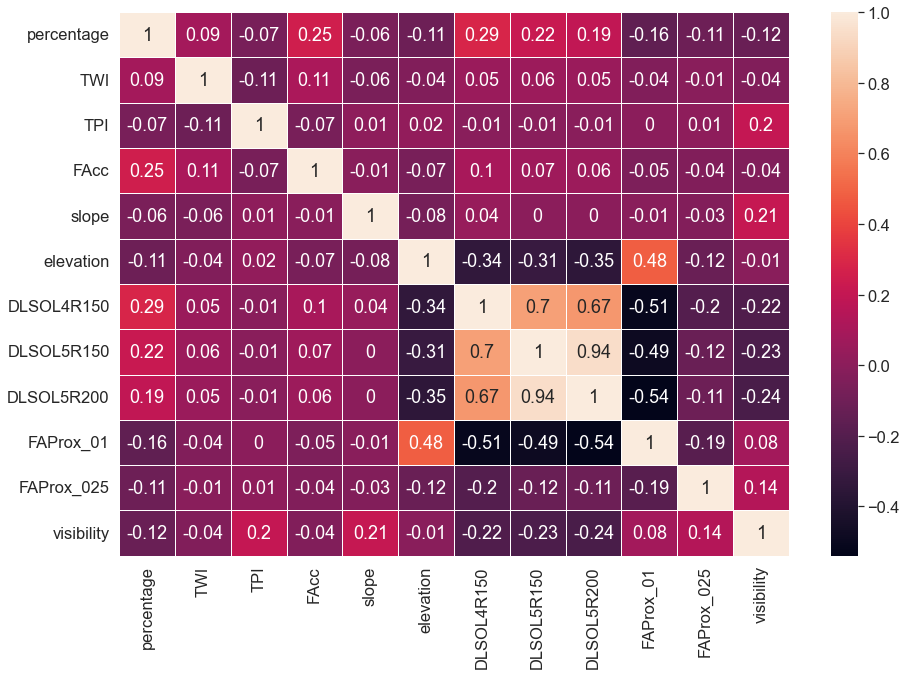

In [95]:

####. Covariance Matrix
fig, ax = plt.subplots(figsize=(15, 10))
ax.font_scale = 9
# sns.set(font_scale=1.5)
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True, linewidth=1)


In [ ]:
DS.drop(['x_coord','y_coord'], axis = 1, inplace=True)
DS.head()

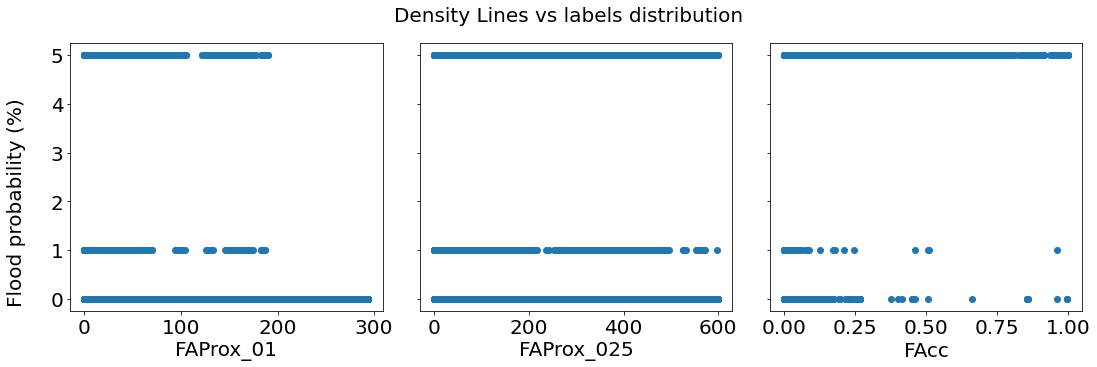

In [49]:
### FAcc vs Labels
targets = DS['percentage']
colList = ['FAProx_01','FAProx_025','FAcc']
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.text(-0.02, 0.5, 'Flood probability (%)', va='center', rotation='vertical')
fig.text(0.5, 1, 'Density Lines vs labels distribution', ha ='center')
j=0
for i in colList:
    axs[j].scatter(DS[i],targets)
    # axs[j].set_title(i)
    axs[j].set(xlabel= i)
    j+=1

plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:

## Plot all features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',

targets = DS['percentage']
# targets = np.where(targets == 5,2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
TPI = DS['TPI']
DLSOL4R150 = DS['LDSOL4R150']
DLSOL5R150 = DS['LDSOL5R150']
DLSOL5R200 = DS['LDSOL5R200']
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']

fig, axs = plt.subplots(4,3, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])

'''
E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
'''
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[3, 0].scatter(TWI,targets)
axs[3, 0].set_title("TWI")

'''
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
'''
axs[0, 1].scatter(TPI,targets)
axs[0, 1].set_title('TPI')
axs[1, 1].scatter(DLSOL4R150,targets)
axs[1, 1].set_title("DLSOL4R150")
axs[2, 1].scatter(DLSOL5R150,targets)
axs[2, 1].set_title("DLSOL5R150")
axs[3, 1].scatter(DLSOL5R200,targets)
axs[3, 1].set_title("DLSOL5R200")

'''
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']
'''
axs[0, 2].scatter(FAProx_01,targets)
axs[0, 2].set_title('FAProx_01')
axs[1, 2].scatter(FAProx_025,targets)
axs[1, 2].set_title("FAProx_025")
axs[2, 2].scatter(visibility,targets)
axs[2, 2].set_title("Visibility")

fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] 
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [ ]:
classifier = ms.loadModel('outputs/2022-11-01/10-51-40/2211011051.pkl')
x_test,y_test = ms.importDataSet('datasets/datasets4MLP_Binary/MLPBinary_basin1_Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

md.plot_ROC_AUC(classifier, x_test, y_test)

In [ ]:
#### ROC_AUC binary for multiples results in the same figure 

fig, axs = plt.subplots(1,figsize=(13,4), sharey=True)
plt.rcParams.update({'font.size': 14})
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.figure(0).clf()
axs.set_title('MLP binary in Basin 5')

classifierList = ['outputs/2022-11-02/09-30-03/2211020930.pkl', 'outputs/2022-10-31/09-57-31/2210310957.pkl']
testSetList = ['datasets/datasets4MLP_Binary/MLPBinary_basin5_Test.csv', 'datasets/datasets4MLP_Binary/MLPBinary_basin5_VsAll_Test.csv']
nameList = ['Intra-Basins','one-vs-rest']
for i in range(len(classifierList)):
    classifier = ms.loadModel(classifierList[i])
    x_test,y_test = ms.importDataSet(testSetList[i], 'percentage')
    x_test = ms.removeCoordinatesFromDataSet(x_test)
    y_prob = classifier.predict_proba(x_test)  
    y_hat = classifier.predict(x_test)
    fpr,tpr,thresholds = metrics.roc_curve(y_test, y_prob[:,1], drop_intermediate=False) 
    print(thresholds)
    roc_auc = roc_auc_score(y_test, y_hat, average = "macro")
    axs.plot(fpr,tpr,label = str(nameList[i]) + " AUC : " + format(roc_auc,".4f")) 
    axs.legend()

## WhiteBoxTool applications

In [ ]:
import whiteboxApplications as wbtapp

In [ ]:
wdir = '/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodMaps/WBTWorkDir'
rtools = wbtapp.rasterTools(wdir)

In [ ]:
for i in range(0,10):
    rtools.gaussianFilter('basin1_FAccDInfLogGauss2.tif', 'basin1_FAccDInfLogGauss2.tif', sigma = 0.70)